In [4]:
import numpy as np
import os
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Activation functions:

In [7]:
def relu(x):
    assert isinstance(x, np.ndarray), "Input to ReLU must be a numpy array"
    result = np.maximum(0, x)
    assert np.all(result >= 0), "ReLU output must be non-negative"
    return result

def relu_derivative(x):
    assert isinstance(x, np.ndarray), "Input to ReLU derivative must be a numpy array"
    result = (x > 0).astype(float)
    assert np.all((result == 0) | (result == 1)), "ReLU derivative must be 0 or 1"
    return result

def softmax(x):
    assert isinstance(x, np.ndarray), "Input to softmax must be a numpy array"
    # Stability improvement: subtract max to prevent overflow
    x_stable = x - np.max(x, axis=1, keepdims=True)
    exp_x = np.exp(x_stable)
    result = exp_x / np.sum(exp_x, axis=1, keepdims=True)
    assert np.all((result >= 0) & (result <= 1)), "Softmax output must be in [0, 1]"
    assert np.allclose(np.sum(result, axis=1), 1), "Softmax output must sum to 1 per sample"
    return result

### MultiClassNeuralNetwork Class:

In [12]:
class MultiClassNeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01, l2_lambda=0.01):
        assert isinstance(layer_sizes, list) and len(layer_sizes) >= 2, "layer_sizes must be a list with at least 2 elements"
        assert all(isinstance(size, int) and size > 0 for size in layer_sizes), "All layer sizes must be positive integers"
        assert isinstance(learning_rate, (int, float)) and learning_rate > 0, "Learning rate must be a positive number"
        assert isinstance(l2_lambda, (int, float)) and l2_lambda >= 0, "L2 regularization parameter must be non-negative"

        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda
        self.weights = []
        self.biases = []

        # Initialization of weights and biases
        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * 0.01
            b = np.zeros((1, layer_sizes[i + 1]))
            assert w.shape == (layer_sizes[i], layer_sizes[i + 1]), f"Weight matrix {i + 1} has incorrect shape"
            assert b.shape == (1, layer_sizes[i + 1]), f"Bias vector {i + 1} has incorrect shape"
            self.weights.append(w)
            self.biases.append(b)

    def forward(self, X):
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        self.activations = [X]
        self.z_values = []

        # Forward pass through hidden layers
        for i in range(len(self.weights) - 1):
            z = self.activations[i] @ self.weights[i] + self.biases[i]
            assert z.shape == (X.shape[0], self.layer_sizes[i + 1]), f"Z^{[{i + 1}]} has incorrect shape"
            self.z_values.append(z)
            self.activations.append(relu(z))

        # Output layer
        z = self.activations[-1] @ self.weights[-1] + self.biases[-1]
        assert z.shape == (X.shape[0], self.layer_sizes[-1]), "Output Z has incorrect shape"
        self.z_values.append(z)
        output = softmax(z)
        assert output.shape == (X.shape[0], self.layer_sizes[-1]), "Output A has incorrect shape"
        self.activations.append(output)

        return self.activations[-1]

    def compute_loss(self, y_true, y_pred):
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to loss must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"

        m = y_true.shape[0]
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        cross_entropy_loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
        
        # L2 regularization term: (lambda/2m) * sum(W^2)
        l2_loss = 0
        for w in self.weights:
            l2_loss += np.sum(np.square(w))
        l2_loss = (self.l2_lambda / (2 * m)) * l2_loss

        total_loss = cross_entropy_loss + l2_loss
        assert not np.isnan(total_loss), "Loss computation resulted in NaN"
        return total_loss

    def compute_accuracy(self, y_true, y_pred):
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to accuracy must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"

        predictions = np.argmax(y_pred, axis=1)
        true_labels = np.argmax(y_true, axis=1)
        accuracy = np.mean(predictions == true_labels)
        assert 0 <= accuracy <= 1, "Accuracy must be between 0 and 1"
        return accuracy

    def backward(self, X, y, outputs):
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray) and isinstance(outputs, np.ndarray), "Inputs to backward must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape == outputs.shape, "y and outputs must have the same shape"

        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]
        self.d_biases = [np.zeros_like(b) for b in self.biases]

        # Output layer gradient
        dZ = outputs - y  # Gradient pour softmax + cross-entropy
        assert dZ.shape == outputs.shape, "dZ for output layer has incorrect shape"
        self.d_weights[-1] = (self.activations[-2].T @ dZ) / m
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m

        # Hidden layers gradients
        for i in range(len(self.weights) - 2, -1, -1):
            dZ = (dZ @ self.weights[i + 1].T) * relu_derivative(self.z_values[i])
            assert dZ.shape == (X.shape[0], self.layer_sizes[i + 1]), f"dZ^{[{i + 1}]} has incorrect shape"
            self.d_weights[i] = (self.activations[i].T @ dZ) / m
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m

        # Add L2 regularization to weight gradients: dW^{[l]} += lambda * W^{[l]} / m
        for i in range(len(self.weights)):
            self.d_weights[i] += self.l2_lambda * self.weights[i] / m

        # Update parameters
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * self.d_weights[i]
            self.biases[i] -= self.learning_rate * self.d_biases[i]

    def train(self, X, y, X_val, y_val, epochs, batch_size):
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), "X and y must be numpy arrays"
        assert isinstance(X_val, np.ndarray) and isinstance(y_val, np.ndarray), "X_val and y_val must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape[1] == self.layer_sizes[-1], f"Output dimension ({y.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert X_val.shape[1] == self.layer_sizes[0], f"Validation input dimension ({X_val.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y_val.shape[1] == self.layer_sizes[-1], f"Validation output dimension ({y_val.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert isinstance(epochs, int) and epochs > 0, "Epochs must be a positive integer"
        assert isinstance(batch_size, int) and batch_size > 0, "Batch size must be a positive integer"

        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            epoch_loss = 0
            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]

                outputs = self.forward(X_batch)
                epoch_loss += self.compute_loss(y_batch, outputs)
                self.backward(X_batch, y_batch, outputs)

            # Calculate the losses and accuracies
            train_loss = epoch_loss / (X.shape[0] // batch_size)
            train_pred = self.forward(X)
            train_accuracy = self.compute_accuracy(y, train_pred)
            val_pred = self.forward(X_val)
            val_loss = self.compute_loss(y_val, val_pred)
            val_accuracy = self.compute_accuracy(y_val, val_pred)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                      f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        outputs = self.forward(X)
        predictions = np.argmax(outputs, axis=1)
        assert predictions.shape == (X.shape[0],), "Predictions have incorrect shape"
        return predictions

# Define the path to the decompressed folder.
data_dir = os.path.join(os.getcwd(), './amhcd-data-64/tifinagh-images')
print(data_dir)
current_working_directory = os.getcwd()
print(current_working_directory)

# Load the CSV file containing the labels
try:
    labels_df = pd.read_csv(os.path.join(data_dir, './amhcd-data-64/labels-map.csv'))
    assert 'image_path' in labels_df.columns and 'label' in labels_df.columns, "CSV must contain 'image_path' and 'label' columns"
except FileNotFoundError:
    print("labels-map.csv not found. Please check the dataset structure.")
    # Alternative: build a DataFrame from the folders
    image_paths = []
    labels = []
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                image_paths.append(os.path.join(label_path, img_name))
                labels.append(label_dir)
    labels_df = pd.DataFrame({'image_path': image_paths, 'label': labels})

# Check the DataFrame
assert not labels_df.empty, "No data loaded. Check dataset files."
print(f"Loaded {len(labels_df)} samples with {labels_df['label'].nunique()} unique classes.")

# Encode the labels
label_encoder = LabelEncoder()
labels_df['label_encoded'] = label_encoder.fit_transform(labels_df['label'])
num_classes = len(label_encoder.classes_)

# Function to load and preprocess an image
def load_and_preprocess_image(image_path, target_size=(32, 32)):
    assert os.path.exists(image_path), f"Image not found: {image_path}"
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    assert img is not None, f"Failed to load image: {image_path}"
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0  # Normalisation
    return img.flatten()  # Flatten for the neural network

# Load all the images
X = np.array([load_and_preprocess_image(os.path.join(data_dir, path)) for path in labels_df['image_path']])
y = labels_df['label_encoded'].values

# Check the dimensions
assert X.shape[0] == y.shape[0], "Mismatch between number of images and labels"
assert X.shape[1] == 32 * 32, f"Expected flattened image size of {32*32}, got {X.shape[1]}"

# Split into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# Explicitly convert to NumPy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == X.shape[0], "Train-val-test split sizes must sum to total samples"

print(f"Train: {X_train.shape[0]} samples, Validation: {X_val.shape[0]} samples, Test: {X_test.shape[0]} samples")

# One-hot encode the labels for multiclass classification
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_train_one_hot = np.array(one_hot_encoder.fit_transform(y_train.reshape(-1, 1)))
y_val_one_hot = np.array(one_hot_encoder.transform(y_val.reshape(-1, 1)))
y_test_one_hot = np.array(one_hot_encoder.transform(y_test.reshape(-1, 1)))

# Check that the one-hot arrays are NumPy arrays
assert isinstance(y_train_one_hot, np.ndarray), "y_train_one_hot must be a numpy array"
assert isinstance(y_val_one_hot, np.ndarray), "y_val_one_hot must be a numpy array"
assert isinstance(y_test_one_hot, np.ndarray), "y_test_one_hot must be a numpy array"

# Create and train the model
layer_sizes = [X_train.shape[1], 64, 32, num_classes]  # 64 et 32 neurones cachés, 33 classes
nn = MultiClassNeuralNetwork(layer_sizes, learning_rate=0.01, l2_lambda=0.01)
train_losses, val_losses, train_accuracies, val_accuracies = nn.train(
    X_train, y_train_one_hot, X_val, y_val_one_hot, epochs=100, batch_size=32
)

# Predictions and evaluation
y_pred = nn.predict(X_test)
print("\nRapport de classification (Test set):")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


/Users/macray/Desktop/University/S2/Deep Learning/TIFINAGH/./amhcd-data-64/tifinagh-images
/Users/macray/Desktop/University/S2/Deep Learning/TIFINAGH
labels-map.csv not found. Please check the dataset structure.
Loaded 28182 samples with 33 unique classes.
Train: 16908 samples, Validation: 5637 samples, Test: 5637 samples
Epoch 0, Train Loss: 3.5043, Val Loss: 3.4965, Train Acc: 0.0392, Val Acc: 0.0369
Epoch 10, Train Loss: 3.5038, Val Loss: 3.4959, Train Acc: 0.0502, Val Acc: 0.0513
Epoch 20, Train Loss: 3.0901, Val Loss: 3.0576, Train Acc: 0.0895, Val Acc: 0.0908
Epoch 30, Train Loss: 2.3848, Val Loss: 2.3603, Train Acc: 0.2900, Val Acc: 0.2778
Epoch 40, Train Loss: 1.6250, Val Loss: 1.6587, Train Acc: 0.5059, Val Acc: 0.4839
Epoch 50, Train Loss: 1.1814, Val Loss: 1.2087, Train Acc: 0.6485, Val Acc: 0.6166
Epoch 60, Train Loss: 0.8706, Val Loss: 0.8869, Train Acc: 0.7535, Val Acc: 0.7218
Epoch 70, Train Loss: 0.6617, Val Loss: 0.7032, Train Acc: 0.8185, Val Acc: 0.7772
Epoch 80, Tra

### Confusion Matrix:

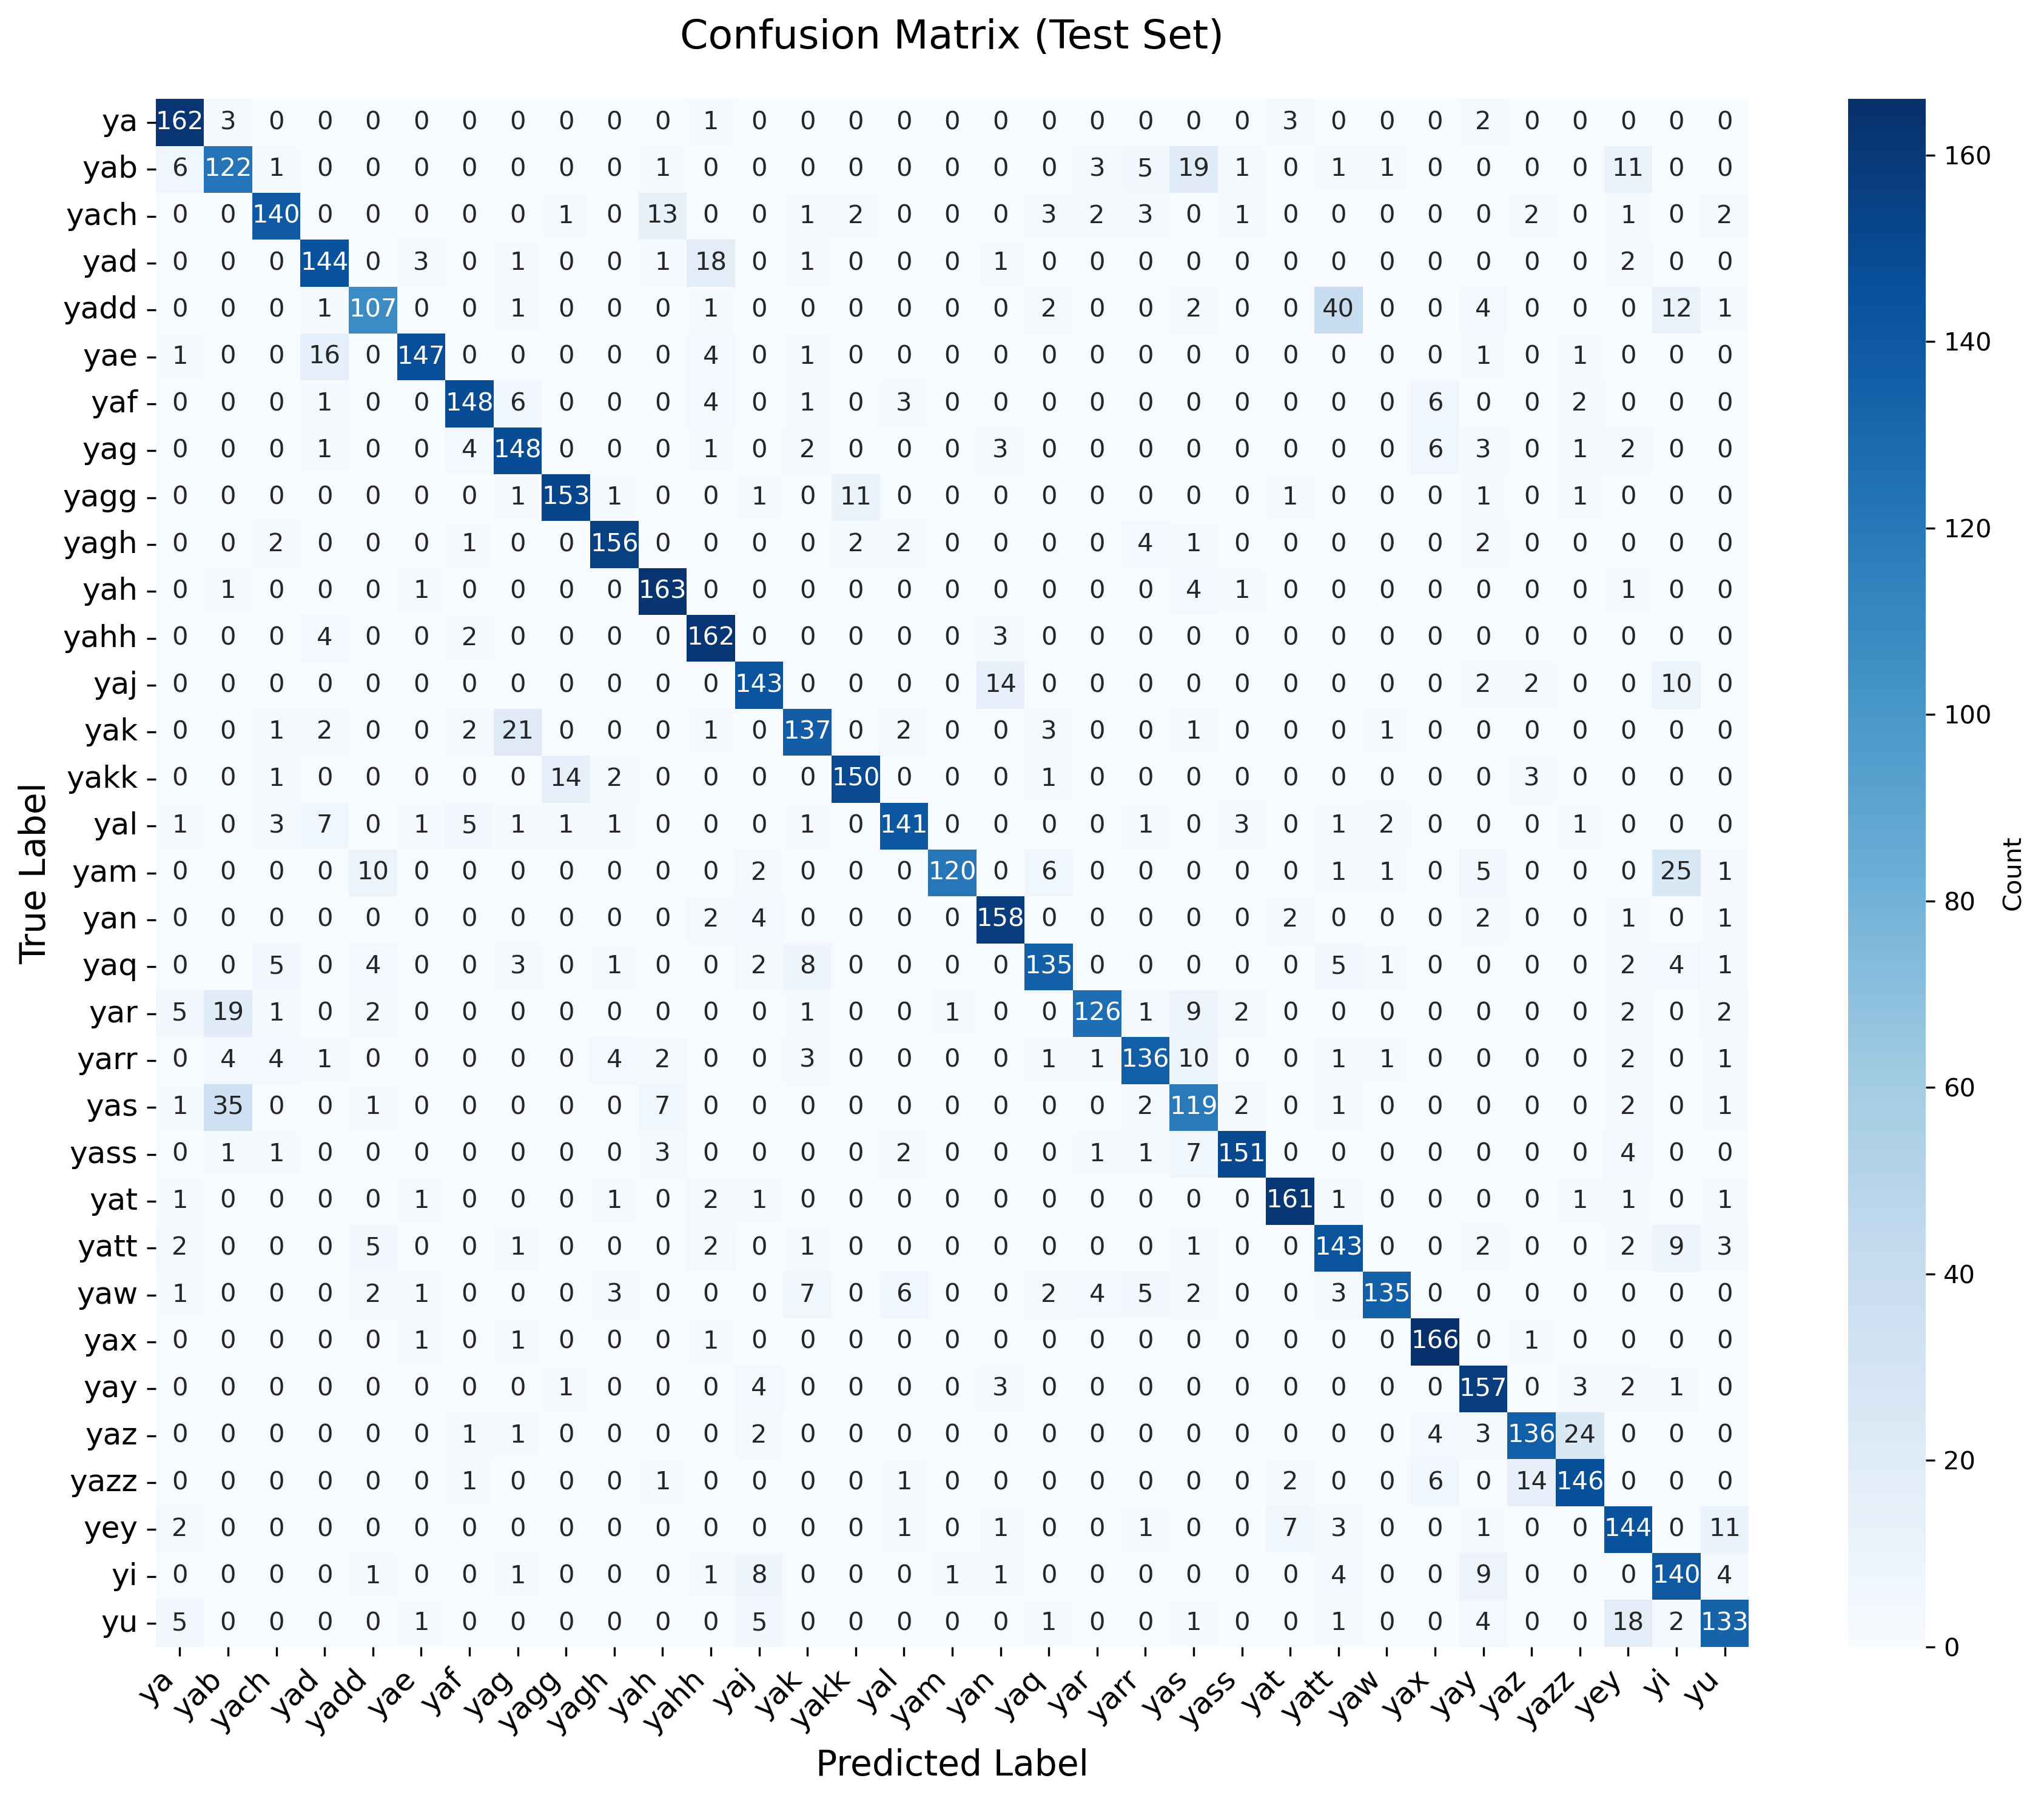

In [15]:
plt.figure(figsize=(12, 10), dpi=300)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'}, 
            annot_kws={"size": 10})
plt.title('Confusion Matrix (Test Set)', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_high_quality.png', bbox_inches='tight', dpi=300)
plt.show()

### Loss and Accuracy curves:

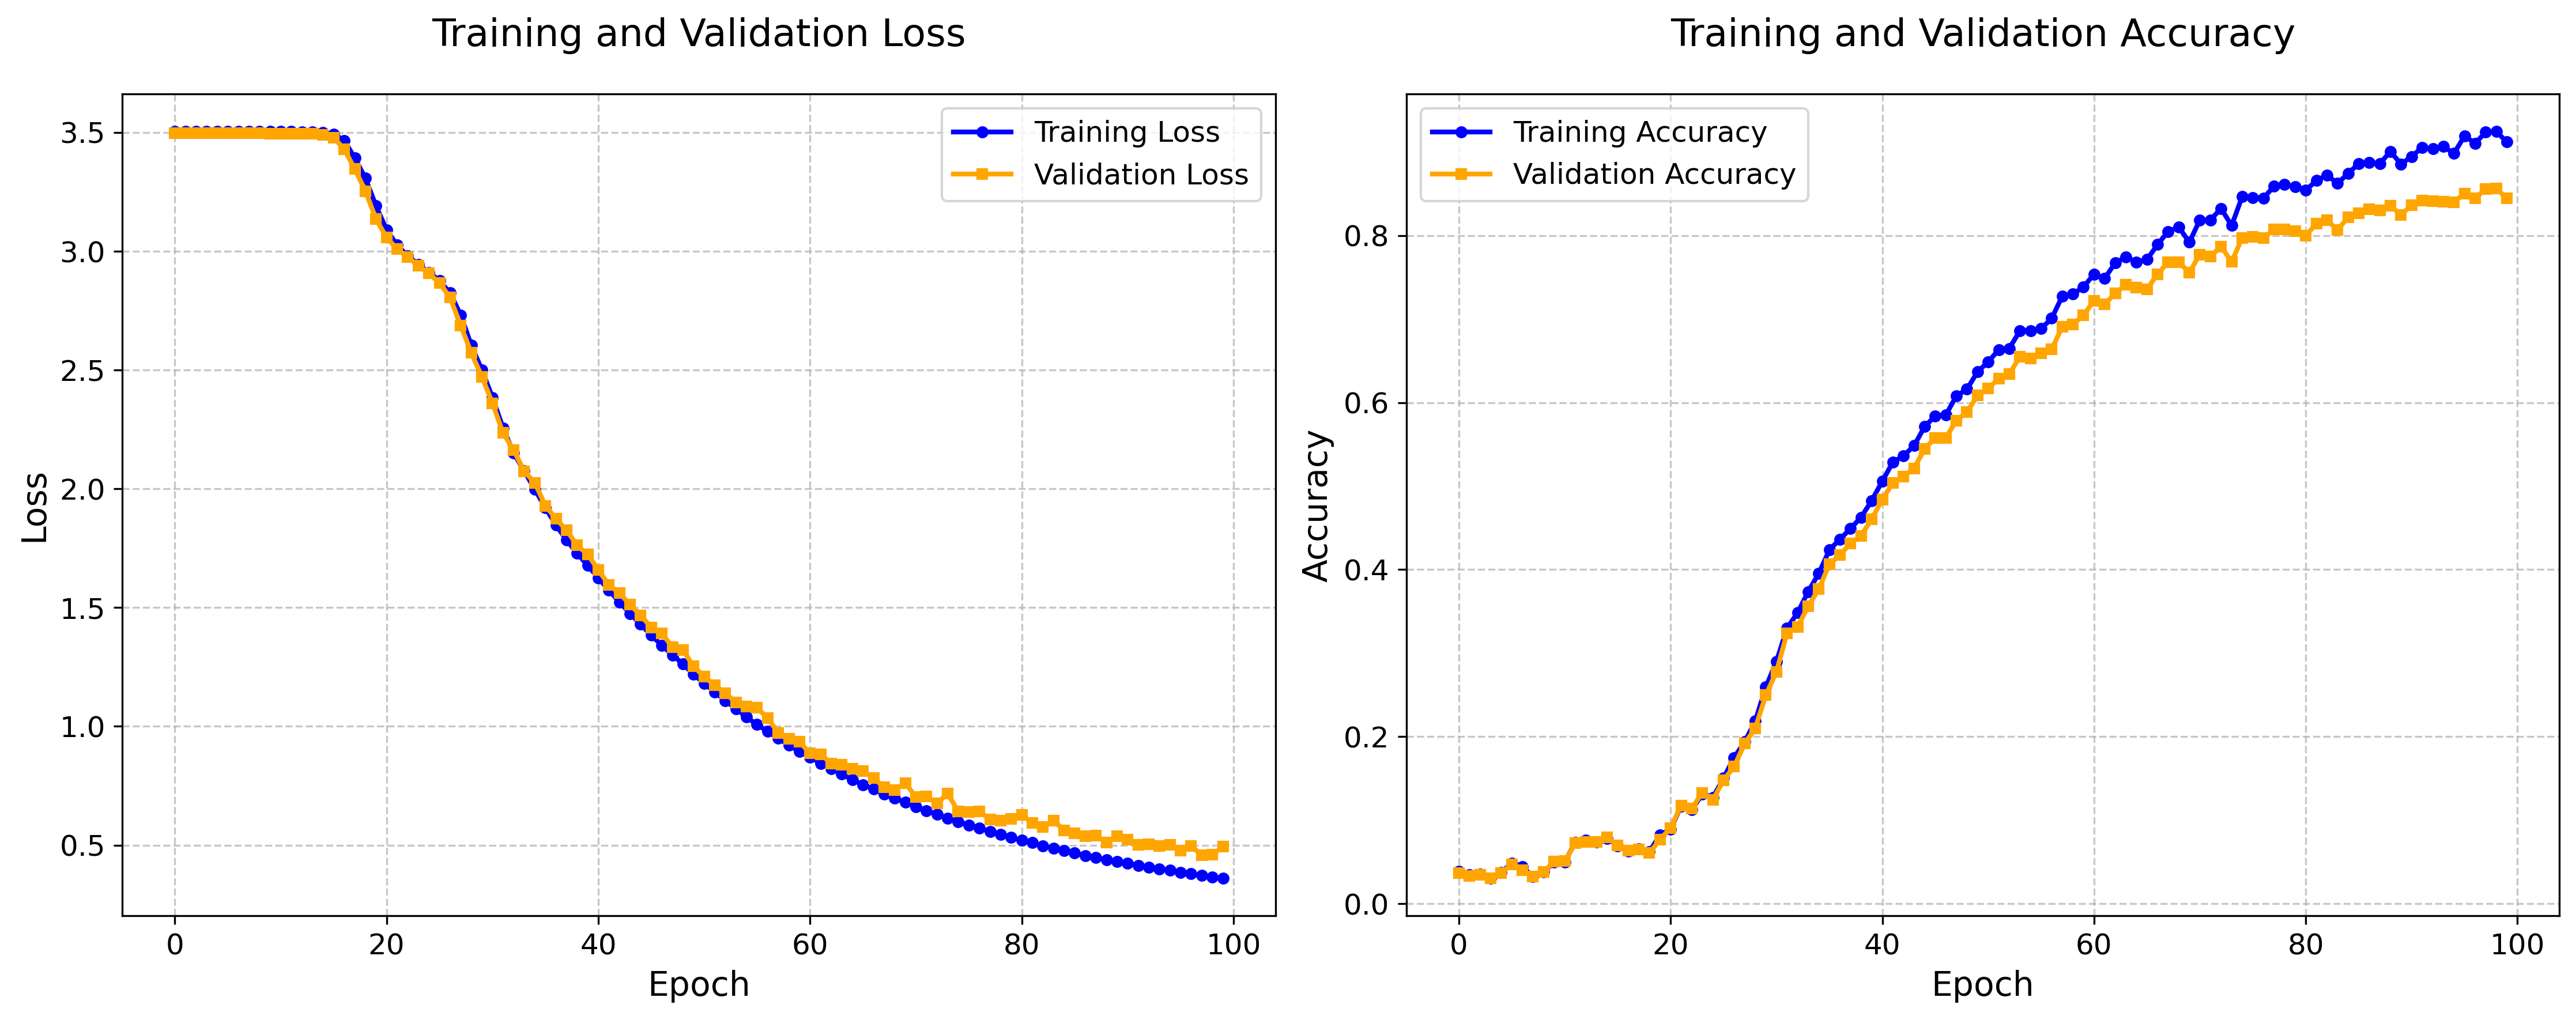

In [18]:
plt.figure(figsize=(15, 6), dpi=300)

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2, marker='o', markersize=4)
plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2, marker='s', markersize=4)
plt.title('Training and Validation Loss', fontsize=16, pad=20)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue', linewidth=2, marker='o', markersize=4)
plt.plot(val_accuracies, label='Validation Accuracy', color='orange', linewidth=2, marker='s', markersize=4)
plt.title('Training and Validation Accuracy', fontsize=16, pad=20)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig('loss_accuracy_curves_high_quality.png', bbox_inches='tight', dpi=300)
plt.show()